In [1]:
import pandas as pd
import numpy as np
np.random.seed(130)
cols = pd.read_csv("var_names.csv")
data = pd.read_csv("CSCS_data_anon.csv",
                   na_values=["9999", "", " ", "Presented but no response", "NA"])
empty = (data.isna().sum()==data.shape[0])
data = data[empty.index[~empty]] # keep non empty columns only

data.shape

/tmp/ipykernel_136/4148703477.py:5: DtypeWarning: Columns (129,408,630,671,689,978,1001,1002,1006,1007,1008,1080,1113,1115,1116,1117,1118,1119,1120,1121,1124,1125,1126,1127,1128,1213,1214,1215,1216,1217,1218,1263,1266,1342,1343,1344,1345,1346,1347,1348,1349,1390,1391,1393,1439,1442,1463,1546,1549,1552,1555,1558,1561) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("CSCS_data_anon.csv",


(11431, 1779)

In [2]:
dataV2 = data[data.REMOVE_case=='No'].copy()
dataV2.shape

(10018, 1779)

In [3]:
data2021 = dataV2[dataV2['SURVEY_collection_year'] == 2021].copy()
data2021.shape

(3186, 1779)

In [4]:
data2021['CONNECTION_time_with_others_satisfied'].value_counts()

CONNECTION_time_with_others_satisfied
Yes                                           1480
No, I want to spend MORE time with others.    1237
No, I want to spend LESS time with others.      75
Name: count, dtype: int64

In [5]:
p_0 = 1480/(1480 + 1237 + 75)
p_1 = 1237 /(1480 + 1237 + 75)
p_2 = 75 /(1480 + 1237 + 75)
mask = data2021['CONNECTION_time_with_others_satisfied'].isna()

# Generate random "Yes" or "No" for missing values
random_values = np.random.choice(["Yes", "No, I want to spend MORE time with others.", "No, I want to spend LESS time with others."], size=mask.sum(), p=[p_0, p_1, p_2])

# Assign random values to missing entries
data2021.loc[mask, 'CONNECTION_time_with_others_satisfied'] = random_values

In [6]:
data2021['CONNECTION_time_with_others_satisfied'].value_counts()

CONNECTION_time_with_others_satisfied
Yes                                           1686
No, I want to spend MORE time with others.    1417
No, I want to spend LESS time with others.      83
Name: count, dtype: int64

In [7]:
data2021['CONNECTION_time_with_others_satisfied_yes'] = data2021['CONNECTION_time_with_others_satisfied'] == 'Yes'

In [8]:
data2021['WELLNESS_life_satisfaction'].fillna(data2021['WELLNESS_life_satisfaction'].mean(), inplace=True)

In [9]:
data2021['CONNECTION_social_media_visits_per_day'].fillna('Missing', inplace=True)
data2021['CONNECTION_social_media_time_per_day'].fillna('Missing', inplace=True)
data2021['LIFESTYLE_time_use_balance_media'].fillna('Missing', inplace=True)

In [10]:
data2021['WELLNESS_above_5'] = data2021['WELLNESS_life_satisfaction'] > 5

In [11]:
from sklearn import model_selection
train, test = model_selection.train_test_split(data2021, train_size=0.8)

In [12]:
import statsmodels.formula.api as smf
formula = '''I(CONNECTION_time_with_others_satisfied_yes.astype(int)) ~ 
                C(CONNECTION_social_media_visits_per_day, Treatment(reference = '1-3 times per day'))
'''
logreg = smf.logit(formula, data=train)
logreg_fit = logreg.fit()
logreg_fit.summary()

Optimization terminated successfully.
         Current function value: 0.671967
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                                              Logit Regression Results                                              
====================================================================================================================
Dep. Variable:     I(CONNECTION_time_with_others_satisfied_yes.astype(int))   No. Observations:                 2548
Model:                                                                Logit   Df Residuals:                     2542
Method:                                                                 MLE   Df Model:                            5
Date:                                                      Thu, 28 Nov 2024   Pseudo R-squ.:                 0.02838
Time:                                                              17:09:59   Log-Likelihood:                -1712.2
converged:                                                             True   LL-Null:                       -1762.2
Covariance Type:                                                  nonrobust   LLR p-value:                 5.247e-20
=====================================================================================================================================================================================
                                                                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                             0.3138      0.072      4.339      0.000       0.172       0.455
C(CONNECTION_social_media_visits_per_day, Treatment(reference='1-3 times per day'))[T.4-8 times per day]             -0.2120      0.107     -1.985      0.047      -0.421      -0.003
C(CONNECTION_social_media_visits_per_day, Treatment(reference='1-3 times per day'))[T.9-15 times per day]            -0.7575      0.141     -5.354      0.000      -1.035      -0.480
C(CONNECTION_social_media_visits_per_day, Treatment(reference='1-3 times per day'))[T.Less than once per day]         0.8140      0.186      4.373      0.000       0.449       1.179
C(CONNECTION_social_media_visits_per_day, Treatment(reference='1-3 times per day'))[T.Missing]                       -0.2137      0.120     -1.784      0.074      -0.448       0.021
C(CONNECTION_social_media_visits_per_day, Treatment(reference='1-3 times per day'))[T.More than 15 times per day]    -0.9853      0.164     -6.017      0.000      -1.306      -0.664
=====================================================================================================================================================================================
"""

In [13]:
((train.CONNECTION_time_with_others_satisfied == 'Yes')==(logreg_fit.predict(train) > 0.5)).sum()/train.shape[0]

0.5784929356357927

In [14]:
((test.CONNECTION_time_with_others_satisfied == 'Yes')==(logreg_fit.predict(test) > 0.5)).sum()/test.shape[0]

0.5611285266457681

In [15]:
formula = '''I(CONNECTION_time_with_others_satisfied_yes.astype(int)) ~ 
                C(CONNECTION_social_media_time_per_day, Treatment(reference = '10-30 minutes per day')) 
'''
logreg = smf.logit(formula, data=train)
logreg_fit = logreg.fit()
logreg_fit.summary()

Optimization terminated successfully.
         Current function value: 0.682033
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                                              Logit Regression Results                                              
====================================================================================================================
Dep. Variable:     I(CONNECTION_time_with_others_satisfied_yes.astype(int))   No. Observations:                 2548
Model:                                                                Logit   Df Residuals:                     2541
Method:                                                                 MLE   Df Model:                            6
Date:                                                      Thu, 28 Nov 2024   Pseudo R-squ.:                 0.01382
Time:                                                              17:09:59   Log-Likelihood:                -1737.8
converged:                                                             True   LL-Null:                       -1762.2
Covariance Type:                                                  nonrobust   LLR p-value:                 8.480e-09
=========================================================================================================================================================================================
                                                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                 0.3185      0.091      3.495      0.000       0.140       0.497
C(CONNECTION_social_media_time_per_day, Treatment(reference='10-30 minutes per day'))[T.1-2 hours per day]               -0.2482      0.133     -1.866      0.062      -0.509       0.012
C(CONNECTION_social_media_time_per_day, Treatment(reference='10-30 minutes per day'))[T.2-3 hours per day]               -0.5199      0.153     -3.404      0.001      -0.819      -0.221
C(CONNECTION_social_media_time_per_day, Treatment(reference='10-30 minutes per day'))[T.31-60 minutes per day]           -0.0402      0.125     -0.322      0.748      -0.285       0.205
C(CONNECTION_social_media_time_per_day, Treatment(reference='10-30 minutes per day'))[T.Less than 10 minutes per day]     0.4000      0.216      1.856      0.063      -0.022       0.822
C(CONNECTION_social_media_time_per_day, Treatment(reference='10-30 minutes per day'))[T.Missing]                         -0.2306      0.133     -1.740      0.082      -0.490       0.029
C(CONNECTION_social_media_time_per_day, Treatment(reference='10-30 minutes per day'))[T.More than 3 hours per day]       -0.8186      0.159     -5.137      0.000      -1.131      -0.506
=========================================================================================================================================================================================
"""

In [16]:
((train.CONNECTION_time_with_others_satisfied == 'Yes')==(logreg_fit.predict(train) > 0.5)).sum()/train.shape[0]

0.5624018838304553

In [17]:
((test.CONNECTION_time_with_others_satisfied == 'Yes')==(logreg_fit.predict(test) > 0.5)).sum()/test.shape[0]

0.5736677115987461

In [18]:
import statsmodels.formula.api as smf
formula = '''I(CONNECTION_time_with_others_satisfied_yes.astype(int)) ~ 
                C(LIFESTYLE_time_use_balance_media, Treatment(reference='Just the right amount'))
'''
logreg = smf.logit(formula, data=train)
logreg_fit = logreg.fit()
logreg_fit.summary()

Optimization terminated successfully.
         Current function value: 0.676356
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                                              Logit Regression Results                                              
====================================================================================================================
Dep. Variable:     I(CONNECTION_time_with_others_satisfied_yes.astype(int))   No. Observations:                 2548
Model:                                                                Logit   Df Residuals:                     2544
Method:                                                                 MLE   Df Model:                            3
Date:                                                      Thu, 28 Nov 2024   Pseudo R-squ.:                 0.02203
Time:                                                              17:09:59   Log-Likelihood:                -1723.4
converged:                                                             True   LL-Null:                       -1762.2
Covariance Type:                                                  nonrobust   LLR p-value:                 9.789e-17
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           0.4724      0.063      7.544      0.000       0.350       0.595
C(LIFESTYLE_time_use_balance_media, Treatment(reference='Just the right amount'))[T.Missing]       -0.3810      0.114     -3.332      0.001      -0.605      -0.157
C(LIFESTYLE_time_use_balance_media, Treatment(reference='Just the right amount'))[T.Too little]    -0.3807      0.139     -2.746      0.006      -0.652      -0.109
C(LIFESTYLE_time_use_balance_media, Treatment(reference='Just the right amount'))[T.Too much]      -0.8401      0.096     -8.715      0.000      -1.029      -0.651
===================================================================================================================================================================
"""

In [19]:
((train.CONNECTION_time_with_others_satisfied == 'Yes')==(logreg_fit.predict(train) > 0.5)).sum()/train.shape[0]

0.5828100470957613

In [20]:
((test.CONNECTION_time_with_others_satisfied == 'Yes')==(logreg_fit.predict(test) > 0.5)).sum()/test.shape[0]

0.5909090909090909

In [21]:
import statsmodels.formula.api as smf
formula = '''I(WELLNESS_above_5.astype(int)) ~ 
                    C(CONNECTION_social_media_visits_per_day, Treatment(reference='1-3 times per day'))+
                    C(CONNECTION_social_media_time_per_day) +
                    C(LIFESTYLE_time_use_balance_media)
'''
logreg = smf.logit(formula, data=train)
logreg_fit2 = logreg.fit()
logreg_fit2.summary()

Optimization terminated successfully.
         Current function value: 0.630624
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Logit Regression Results                                 
===========================================================================================
Dep. Variable:     I(WELLNESS_above_5.astype(int))   No. Observations:                 2548
Model:                                       Logit   Df Residuals:                     2533
Method:                                        MLE   Df Model:                           14
Date:                             Thu, 28 Nov 2024   Pseudo R-squ.:                 0.02495
Time:                                     17:09:59   Log-Likelihood:                -1606.8
converged:                                    True   LL-Null:                       -1648.0
Covariance Type:                         nonrobust   LLR p-value:                 1.082e-11
=====================================================================================================================================================================================
                                                                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                             0.8951      0.134      6.674      0.000       0.632       1.158
C(CONNECTION_social_media_visits_per_day, Treatment(reference='1-3 times per day'))[T.4-8 times per day]             -0.0587      0.117     -0.502      0.615      -0.288       0.170
C(CONNECTION_social_media_visits_per_day, Treatment(reference='1-3 times per day'))[T.9-15 times per day]            -0.1858      0.160     -1.160      0.246      -0.500       0.128
C(CONNECTION_social_media_visits_per_day, Treatment(reference='1-3 times per day'))[T.Less than once per day]         0.1234      0.189      0.651      0.515      -0.248       0.495
C(CONNECTION_social_media_visits_per_day, Treatment(reference='1-3 times per day'))[T.Missing]                        0.3326      0.653      0.510      0.610      -0.947       1.612
C(CONNECTION_social_media_visits_per_day, Treatment(reference='1-3 times per day'))[T.More than 15 times per day]    -0.4053      0.194     -2.088      0.037      -0.786      -0.025
C(CONNECTION_social_media_time_per_day)[T.10-30 minutes per day]                                                     -0.3609      0.148     -2.440      0.015      -0.651      -0.071
C(CONNECTION_social_media_time_per_day)[T.2-3 hours per day]                                                         -0.3593      0.165     -2.174      0.030      -0.683      -0.035
C(CONNECTION_social_media_time_per_day)[T.31-60 minutes per day]                                                     -0.1556      0.138     -1.124      0.261      -0.427       0.116
C(CONNECTION_social_media_time_per_day)[T.Less than 10 minutes per day]                                              -0.2698      0.244     -1.104      0.270      -0.749       0.209
C(CONNECTION_social_media_time_per_day)[T.Missing]                                                                    0.4928      0.766      0.644      0.520      -1.008       1.993
C(CONNECTION_social_media_time_per_day)[T.More than 3 hours per day]                                                 -0.3496      0.184     -1.903      0.057      -0.710       0.010
C(LIFESTYLE_time_use_balance_media)[T.Missing]                                                                       -0.3987      0.512     -0.779      0.436      -1.401       0.604
C(LIFESTYLE_time_use_balance_media)[T.Too little]                                                                     0.0587      0.147      0.400      0.689      -0.229       0.347
C(LIFESTYLE_time_use_balance_m

In [22]:
((train.CONNECTION_time_with_others_satisfied == 'Yes')==(logreg_fit2.predict(train) > 0.5)).sum()/train.shape[0]

0.5498430141287284

In [23]:
((test.CONNECTION_time_with_others_satisfied == 'Yes')==(logreg_fit2.predict(test) > 0.5)).sum()/test.shape[0]

0.5532915360501567

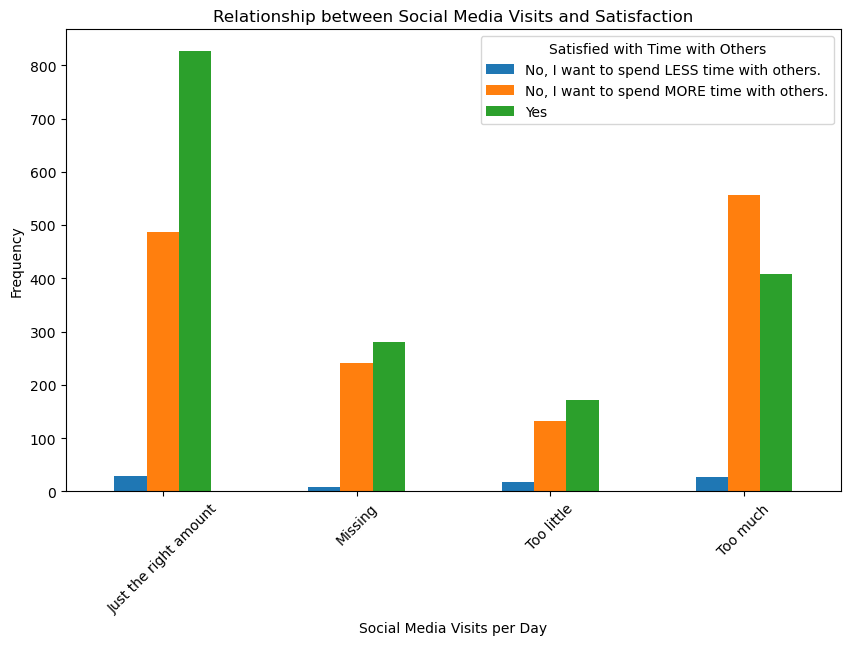

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a crosstab of the two categorical variables
crosstab = pd.crosstab(data2021['LIFESTYLE_time_use_balance_media'], 
                       data2021['CONNECTION_time_with_others_satisfied'])

# Plot the grouped bar chart
crosstab.plot(kind='bar', figsize=(10, 6))
plt.title('Relationship between Social Media Visits and Satisfaction')
plt.xlabel('Social Media Visits per Day')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Satisfied with Time with Others')
plt.show()

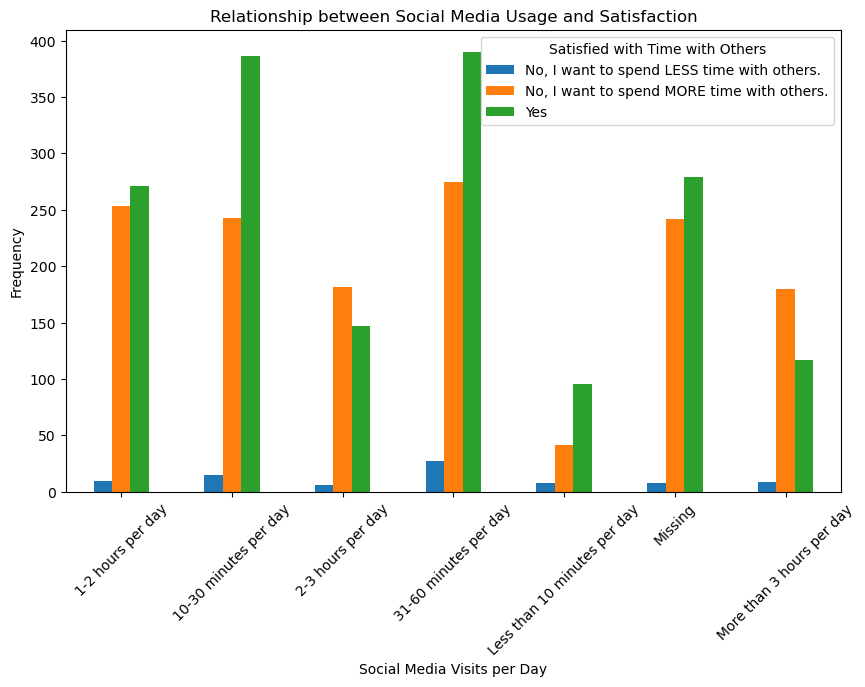

In [25]:
crosstab = pd.crosstab(data2021['CONNECTION_social_media_time_per_day'], 
                       data2021['CONNECTION_time_with_others_satisfied'])

# Plot the grouped bar chart
crosstab.plot(kind='bar', figsize=(10, 6))
plt.title('Relationship between Social Media Usage and Satisfaction')
plt.xlabel('Social Media Visits per Day')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Satisfied with Time with Others')
plt.show()

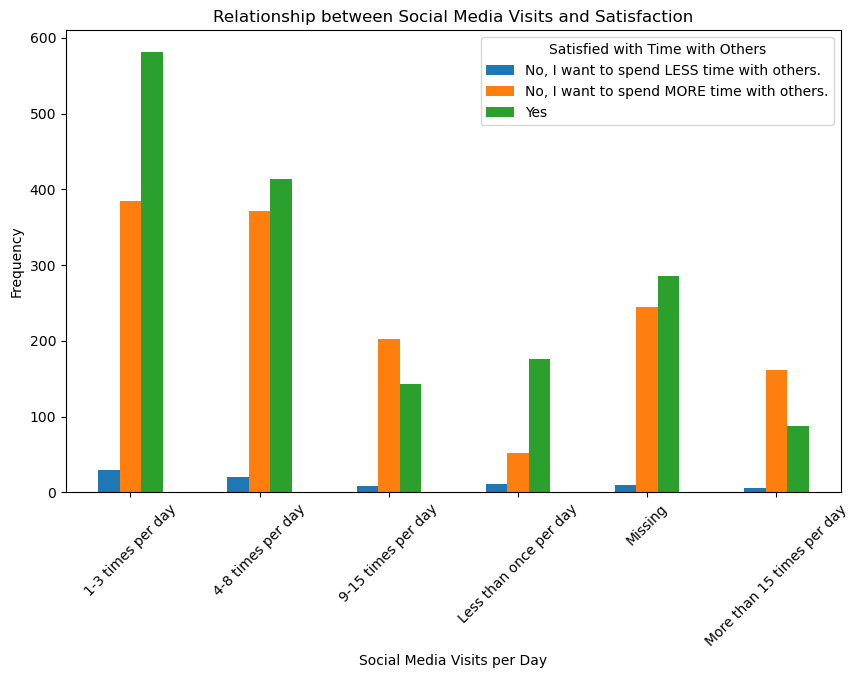

In [26]:
crosstab = pd.crosstab(data2021['CONNECTION_social_media_visits_per_day'], 
                       data2021['CONNECTION_time_with_others_satisfied'])

# Plot the grouped bar chart
crosstab.plot(kind='bar', figsize=(10, 6))
plt.title('Relationship between Social Media Visits and Satisfaction')
plt.xlabel('Social Media Visits per Day')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Satisfied with Time with Others')
plt.show()